# Рекомендательные системы

In [1]:
!pip install --quiet -U jsonlines pyserini jsonlines scikit-surprise fastrank

     |████████████████████████████████| 67.1MB 48kB/s 
     |████████████████████████████████| 11.8MB 57.5MB/s 
     |████████████████████████████████| 901kB 45.8MB/s 
     |████████████████████████████████| 2.0MB 49.9MB/s 
     |████████████████████████████████| 1.1MB 50.5MB/s 
     |████████████████████████████████| 81kB 11.4MB/s 
     |████████████████████████████████| 7.9MB 23.4MB/s 
     |████████████████████████████████| 3.2MB 52.4MB/s 
     |████████████████████████████████| 890kB 44.7MB/s 


# Библиотеки

In [112]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import gridspec

from tqdm.notebook import tqdm
import numpy as np
import  pandas as pd
import seaborn as sns
import torch
import scipy
import json
import re
import os

from functools import partial
from multiprocess import Pool

from surprise import Dataset, Reader, SVD

# Рекомендательные системы

In [3]:
data = Dataset.load_builtin('ml-100k')
trainset = data.build_full_trainset()
dataframe = pd.DataFrame(
    trainset.all_ratings(),
    columns=['uid', 'iid', 'rating'])
dataframe.sample(5, random_state=42)

Dataset ml-100k could not be found. Do you want to download it? [Y/n] y
Trying to download dataset from http://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


,uid,iid,rating
75721,688,145,1.0
80184,742,446,3.0
19864,116,113,5.0
76699,696,587,3.0
92991,877,325,3.0


In [125]:
mapping = dict()
for index in tqdm(dataframe.index):
    item = dataframe.loc[index]
    if item['uid'] not in mapping:
        mapping[item['uid']] = dict()
    mapping[item['uid']][item['iid']] = item['rating']

  0%|          | 0/100000 [00:00<?, ?it/s]

In [71]:
uids = np.unique(dataframe['uid'].values)[:300]
means = {uid: dataframe.loc[dataframe['uid'] == uid]['rating'].values.mean() for uid in uids}

In [126]:
def r(uid, iid=None):
    if uid not in mapping:
        return None
    if iid is None:
        all_iid = mapping.get(uid, None)
        return [(key, all_iid[key]) for key in all_iid]
    else:
        return mapping.get(uid, None).get(iid, None)

In [122]:
def score_model(predictor, metric='std'):
    score = 0
    if metric == 'std':
        total = 0
        number = 0

        for uid in uids:
            for iid, iid_score in r(uid):
                pred = predictor(int(uid), int(iid))
                if pred is not None:
                    total += (iid_score - pred)**2
                    number += 1
        if number is not None:
            score = total / number
        else:
            score = None
    return score


## Константная модель

In [135]:
def predict_user_constant(uid, iid):
    return means[uid]

In [136]:
%%time
predict_user_constant(0, 377)

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 15.5 µs


3.6153846153846154

In [137]:
%%time
score_model(predict_user_constant)

CPU times: user 90.4 ms, sys: 2.99 ms, total: 93.4 ms
Wall time: 95.8 ms


1.103921264013213

## Корреляционная система

$$
  \hat{r}_{ui} = \bar{r}_{u} + \frac{\sum S(u, u')\cdot \left(r_{u'i} - \bar{r}_{u'}\right)}{\sum S(u, u')} 
$$

In [146]:
def predict_user_score(uid, iid, scores):
    weighted_score = 0
    list_of_ids = []

    pair_list = [(id, iid) for id in uids]
    f = lambda x: (x[0], x[1], r(*x))
    
    for id, iid, r_uid_iid in Pool(processes=2).imap_unordered(f, pair_list):
        if id != uid:
            r_id_iid = r(id, iid)
            if r_uid_iid is not None:
                list_of_ids.append(id)
                weighted_score += scores[uid, id]*(r_id_iid - means[id])

    if len(list_of_ids):
        return means[uid] + weighted_score/scores[uid, list_of_ids].sum()
    else:
        return None

### Мера сходства пользователей
$$
  S_{u}\bigr(u_1, u_2\bigr) = ?
$$

#### Определим как ср. кв. отклоение средних оценок
$$
  S_{u}\bigr(u_1, u_2\bigr) = \left(\bar{r}_{u_1} - \bar{r}_{u_2}\right)^2
$$

In [72]:
def user_metric_one(u1, u2):
    r'''
    Оценка схожести объектов на основе квадрата разности средних оценок.

    :param u1: идентификатор первого пользователя
    :type u1: int
    :param u2: иденттификатор второго пользователя
    :type u2: int

    :return: оценку схожести объектов
    :rtype: float
    '''
    ru1 = means[u1]
    ru2 = means[u2]
    return (ru1 - ru2)**2

##### Проанализируем расстояния

In [73]:
scores = np.zeros(shape=[len(uids), len(uids)])

def f(pair):
    i, j = pair
    return i, j, user_metric_one(uids[i], uids[j])

pair_list = [(i, j) \
             for i in range(len(uids)) \
             for j in range(len(uids)) if i < j]

for i, j, score in tqdm(Pool(processes=2).imap_unordered(f, pair_list), total=len(pair_list)):
    scores[i, j] = score
    scores[j, i] = score

  0%|          | 0/44850 [00:00<?, ?it/s]

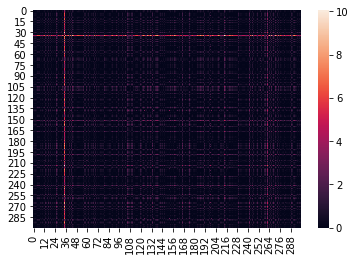

In [92]:
sns.heatmap(data=scores)
plt.show()

In [147]:
%%time
predict_user_score(0, 377, scores)

CPU times: user 395 ms, sys: 67.7 ms, total: 463 ms
Wall time: 510 ms


3.5008090561626926

In [ ]:
%%time
score_model(partial(predict_user_score, scores=scores))

Exception ignored in: <function _releaseLock at 0x7f36fc2fe8c0>
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt
  File "/usr/local/lib/python3.7/dist-packages/multiprocess/connection.py", line 410, in _recv_bytes
    buf = self._recv(4)
  File "/usr/local/lib/python3.7/dist-packages/multiprocess/connection.py", line 410, in _recv_bytes
    buf = self._recv(4)
  File "/usr/local/lib/python3.7/dist-packages/multiprocess/connection.py", line 382, in _recv
    chunk = read(handle, remaining)
  File "/usr/local/lib/python3.7/dist-packages/multiprocess/connection.py", line 382, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
KeyboardInterrupt

During handling of the above exception, another exception occurred:


During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/multiprocess/p

#### Корреляция пирсона 